# V1: with pygame, failed

In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment
%cd PyGame-Learning-Environment
!pip install -e .

fatal: destination path 'PyGame-Learning-Environment' already exists and is not an empty directory.
/content/PyGame-Learning-Environment
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ple
    Found existing installation: ple 0.0.1
    Uninstalling ple-0.0.1:
      Successfully uninstalled ple-0.0.1
  Running setup.py develop for ple


In [ ]:
%cd ..


/content


In [ ]:
%mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
!pip install pygame

In [ ]:
from ple.games.snake import Snake
from ple import PLE

import os
import time
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

ModuleNotFoundError: No module named 'ple'

In [ ]:
game = Snake(32, 32)
p = PLE(game, fps=30, display_screen=True)
p.init()

In [ ]:
game.getGameState()

In [ ]:
game.actions

In [ ]:
p.getActionSet()

## Run the agent that chooses the state randomly

In [ ]:
p.init()
reward = 0.0
nb_frames = 100

p.saveScreen(f'images/step_0.png')

for i in range(nb_frames):
   if p.game_over():
           p.reset_game()

   observation = p.getScreenRGB()
   action = random.choice(p.getActionSet()[:-1])
   reward = p.act(action)
   p.saveScreen(f'images/step_{i + 1}.png')

In [ ]:
fig, ax = plt.subplots()

n_frames = len(os.listdir('images'))

def update(i):
    img = Image.open(f'images/step_{i}.png')
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)

In [ ]:
HTML(ani.to_jshtml())

## Try to train using Polivy Gradient

Used the materials from HuggingFace RL course as a refernce https://huggingface.co/learn/deep-rl-course/unit4/hands-on

In [ ]:
from collections import deque

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, action_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
        self.ln = nn.LayerNorm(288)
        self.fc1 = nn.Linear(288, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.ln(x.flatten())
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

def preprocess_image(image):
    # Convert to tensor and normalize to [0, 1]
    image = torch.FloatTensor(image) / 255.0
    # Add batch and channel dimensions (1 channel for grayscale)
    image = image.unsqueeze(0).unsqueeze(0)
    return image

In [ ]:
game = Snake(32, 32)
rewards = {
    "positive": 1.0,
    "negative": -1.0,
    "tick": 0,
    "loss": -5.0,
    "win": 5.0
}
p = PLE(game, fps=30, display_screen=True, reward_values=rewards)
p.init()

In [ ]:
LEARNING_RATE = 1e-3
GAMMA = 0.7
NUM_EPISODES = 10000
MAX_STEPS = 500

action_dim = len(p.getActionSet()) - 1

# Initialize the policy network and optimizer
policy_net = PolicyNetwork(action_dim)
policy_net = policy_net.to('cuda:0')
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

In [ ]:
def sample_action(state):
    action_probs = policy_net(state).cpu()
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma=GAMMA):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    return torch.FloatTensor(discounted_rewards)

In [ ]:
ep_rewards = []
policy_net.train()
for episode in range(NUM_EPISODES):
    p.reset_game()
    states, actions, rewards, log_probs = [], [], [], []

    for _ in range(MAX_STEPS):
        # Get the grayscale image as the state
        state = p.getScreenGrayscale()
        state = preprocess_image(state)  # Preprocess the image

        state = state.to('cuda:0')
        action, log_prob = sample_action(state)
        log_probs.append(log_prob)
        reward = p.act(p.getActionSet()[action])

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        if p.game_over():
            break

    # Compute discounted rewards
    # print(rewards)
    discounted_rewards = compute_discounted_rewards(rewards)
    # print(discounted_rewards)

    # Normalize discounted rewards
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    # print(discounted_rewards)

    # Convert lists to tensors
    states = torch.cat(states).to('cuda:0')
    actions = torch.LongTensor(actions).to('cuda:0')

    # Compute the policy loss
    # action_probs = policy_net(states)
    # selected_action_probs = action_probs.gather(1, actions.unsqueeze(1))
    # loss = -torch.sum(torch.log(selected_action_probs) * discounted_rewards)

    # print(log_probs)
    # print(discounted_rewards)
    policy_loss = []
    for log_prob, disc_return in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * disc_return)
    # print(policy_loss)
    loss = torch.stack(policy_loss).sum().to('cuda:0')
    # print()

    # Update the policy network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print episode statistics
    ep_rewards.append(sum(rewards))
    # print(rewards)
    # print(actions)
    if episode % 30 == 0:
        print(f"Episode {episode + 1}, Total Reward: {sum(rewards)}, Loss: {loss.detach().cpu().item()}")
    # print()

In [ ]:
plt.plot(list(range(len(ep_rewards))), ep_rewards)
plt.show()

In [ ]:
p.init()
reward = 0.0
nb_frames = 200

policy_net = policy_net.eval()

p.saveScreen(f'images/step_0.png')

for i in range(nb_frames):
    if p.game_over():
           p.reset_game()

    state = p.getScreenGrayscale()
    state = preprocess_image(state)  # Preprocess the image

    state = state.to('cuda:0')
    action, log_prob = sample_action(state)
    reward = p.act(p.getActionSet()[action])
    # observation = p.getScreenRGB()
    p.saveScreen(f'images/step_{i + 1}.png')

In [ ]:
fig, ax = plt.subplots()

n_frames = len(os.listdir('images'))

def update(i):
    img = Image.open(f'images/step_{i}.png')
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
def sample_action(state, policy_net):
    action_probs = policy_net(state).cpu()
    m = Categorical(action_probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [ ]:
LEARNING_RATE = 1e-3
GAMMA = 0.95
NUM_EPISODES = 3000
MAX_STEPS = 800

action_dim = len(p.getActionSet()) - 1

# Initialize the policy network and optimizer
policy_net = PolicyNetwork(action_dim)
policy_net = policy_net.to('cuda:0')
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

In [ ]:
ep_rewards = []
policy_net.train()
for episode in range(NUM_EPISODES):
    p.reset_game()
    states, actions, rewards, log_probs = [], [], [], []

    for _ in range(MAX_STEPS):
        # Get the grayscale image as the state
        state = p.getScreenGrayscale()
        state = preprocess_image(state)  # Preprocess the image

        state = state.to('cuda:0')
        action, log_prob = sample_action(state, policy_net)
        log_probs.append(log_prob)
        reward = p.act(p.getActionSet()[action])

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        if p.game_over():
            break

    discounted_rewards = compute_discounted_rewards(rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    states = torch.cat(states).to('cuda:0')
    actions = torch.LongTensor(actions).to('cuda:0')

    policy_loss = []
    for log_prob, disc_return in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * disc_return)
    loss = torch.stack(policy_loss).sum().to('cuda:0')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ep_rewards.append(sum(rewards))
    if episode % 30 == 0:
        print(f"Episode {episode + 1}, Total Reward: {sum(rewards)}, Loss: {loss.detach().cpu().item()}")

In [ ]:
plt.plot(list(range(len(ep_rewards))), ep_rewards)
plt.show()

In [ ]:
p.init()
reward = 0.0
nb_frames = 200

policy_net = policy_net.eval()

p.saveScreen(f'images/step_0.png')

for i in range(nb_frames):
    if p.game_over():
           p.reset_game()

    state = p.getScreenGrayscale()
    state = preprocess_image(state)  # Preprocess the image

    state = state.to('cuda:0')
    action, log_prob = sample_action(state)
    reward = p.act(p.getActionSet()[action])
    # observation = p.getScreenRGB()
    p.saveScreen(f'images/step_{i + 1}.png')


fig, ax = plt.subplots()
n_frames = len(os.listdir('images'))

def update(i):
    img = Image.open(f'images/step_{i}.png')
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)
plt.close()
HTML(ani.to_jshtml())

# V2, chatgpt env

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

In [ ]:
class SnakeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, grid_size=10, initial_length=3):
        super(SnakeEnv, self).__init__()

        self.grid_size = grid_size
        self.initial_length = initial_length
        self.action_space = spaces.Discrete(4)  # 0: Up, 1: Down, 2: Left, 3: Right
        self.observation_space = spaces.Box(0, 2, (grid_size, grid_size), dtype=np.uint8)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.snake = [(self.grid_size // 2, self.grid_size // 2)]
        self.direction = random.choice([0, 1, 2, 3])

        for _ in range(self.initial_length - 1):
            self._extend_snake()

        self.apple = self._place_apple()
        return self._get_observation(), {}

    def step(self, action):
        if action not in [0, 1, 2, 3]:
            raise ValueError("Invalid action")

        self.direction = action
        new_head = self._move_snake()

        if self._is_collision(new_head):
            return self._get_observation(), -1, True, {}

        self.snake.insert(0, new_head)

        if new_head == self.apple:
            self.apple = self._place_apple()
            reward = 1
        else:
            self.snake.pop()
            reward = 0

        return self._get_observation(), reward, False, {}

    def render(self, mode="human"):
        img = np.ones((self.grid_size, self.grid_size, 3), dtype=np.uint8) * 128  # Gray background

        for x, y in self.snake:
            img[x, y] = [0, 255, 0]  # Green snake
        ax, ay = self.apple
        img[ax, ay] = [255, 0, 0]  # Red apple
        return img

    def _get_observation(self):
        obs = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        for x, y in self.snake:
            obs[x, y] = 1
        ax, ay = self.apple
        obs[ax, ay] = 2
        return obs

    def _move_snake(self):
        head_x, head_y = self.snake[0]
        if self.direction == 0:
            return (head_x - 1, head_y)  # Up
        elif self.direction == 1:
            return (head_x + 1, head_y)  # Down
        elif self.direction == 2:
            return (head_x, head_y - 1)  # Left
        elif self.direction == 3:
            return (head_x, head_y + 1)  # Right

    def _is_collision(self, pos):
        x, y = pos
        return (x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size or pos in self.snake)

    def _place_apple(self):
        while True:
            pos = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if pos not in self.snake:
                return pos

    def _extend_snake(self):
        if self.snake:
            tail_x, tail_y = self.snake[-1]
            self.snake.append((tail_x, tail_y))

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

## Random agent

In [ ]:
# run random agent
class RandomAgentPolicy():
    def act(self, state):
        return random.choice(list(range(4))), None

env = SnakeEnv(grid_size=10)
policy = RandomAgentPolicy()

state = env.reset()
done = False

mean_reward, std_reward = evaluate_agent(env, 200, n_eval_episodes=50, policy=policy)
print(f'Mean reward: {mean_reward}, std: {std_reward}')

state = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    images.append(env.render())

Mean reward: -0.98, std: 0.13999999999999999


In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=300)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
ani.save('snake_random_agent.mp4')

## REINFORCE with CNN as policy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque

In [ ]:
class PolicyCNN(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(PolicyCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

def select_action(policy, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dim
    probs = policy(state)
    distribution = torch.distributions.Categorical(probs)
    action = distribution.sample()
    return action.item(), distribution.log_prob(action)

In [ ]:
def train(env, policy, optimizer, num_episodes=1000, gamma=0.95, max_steps=800, scheduler=None):
    train_rewards = []
    policy = policy.train()
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        log_probs = []
        rewards = []

        steps = 0
        while not done:
            action, log_prob = select_action(policy, state)
            next_state, reward, terminated, info = env.step(action)
            done = terminated

            log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state
            steps += 1
            if steps > max_steps:
                done = True

        # Compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns

        # Compute loss and update policy
        loss = 0
        for log_prob, G in zip(log_probs, returns):
            loss -= log_prob * G

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        train_rewards.append(sum(rewards))
        if episode % 50 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {sum(rewards)}, Loss: {loss.item()}")

    return train_rewards

In [ ]:
class CNNAgentPolicy():
    def __init__(self, policy):
        self.policy = policy.eval()

    def act(self, state):
        # print(state)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        probs = self.policy(state)
        action = torch.argmax(probs)
        return action.item(), None

Episode 1/5000, Total Reward: -1, Loss: -0.058638811111450195
Episode 51/5000, Total Reward: -1, Loss: -0.4879642724990845
Episode 101/5000, Total Reward: -1, Loss: -2.7925729751586914
Episode 151/5000, Total Reward: 0, Loss: 0.43747204542160034
Episode 201/5000, Total Reward: -1, Loss: -0.41104423999786377
Episode 251/5000, Total Reward: -1, Loss: -0.340604305267334
Episode 301/5000, Total Reward: -1, Loss: -0.25600647926330566
Episode 351/5000, Total Reward: -1, Loss: 0.7926204800605774
Episode 401/5000, Total Reward: -1, Loss: 0.5120987892150879
Episode 451/5000, Total Reward: -1, Loss: -0.9278950691223145
Episode 501/5000, Total Reward: -1, Loss: -0.030651569366455078
Episode 551/5000, Total Reward: 0, Loss: 0.13151037693023682
Episode 601/5000, Total Reward: -1, Loss: 1.4024739265441895
Episode 651/5000, Total Reward: -1, Loss: -0.48146528005599976
Episode 701/5000, Total Reward: -1, Loss: -2.165383815765381
Episode 751/5000, Total Reward: -1, Loss: -1.7077007293701172
Episode 801

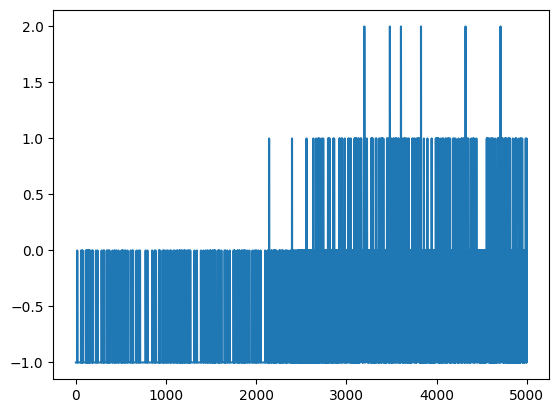

In [ ]:
LR = 1e-3
GAMMA = 0.95
EPISODES = 5000
MAX_STEPS = 800

env = SnakeEnv(grid_size=10, initial_length=3)
input_channels = 1
output_dim = env.action_space.n

policy = PolicyCNN(input_channels, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=LR)

rewards = train(env, policy, optimizer, num_episodes=EPISODES, gamma=GAMMA, max_steps=MAX_STEPS)

plt.plot(list(range(len(rewards))), rewards)
plt.show()

In [ ]:
env = SnakeEnv(grid_size=10)
cnn_policy = CNNAgentPolicy(policy)

state, _ = env.reset()
done = False

mean_reward, std_reward = evaluate_agent(env, 200, n_eval_episodes=50, policy=cnn_policy)
print(f'Mean reward: {mean_reward}, std: {std_reward}')

state, _ = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = cnn_policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    state = new_state
    images.append(env.render())

Mean reward: 0.06, std: 0.5800000000000001


In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=300)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
ani.save('snake_attempt1.mp4')

Episode 1/5000, Total Reward: -1, Loss: -0.03559529781341553
Episode 51/5000, Total Reward: -1, Loss: -0.014627337455749512
Episode 101/5000, Total Reward: -1, Loss: -0.024045944213867188
Episode 151/5000, Total Reward: -1, Loss: -0.011158324778079987
Episode 201/5000, Total Reward: -1, Loss: -0.01085750013589859
Episode 251/5000, Total Reward: -1, Loss: -0.6038431525230408
Episode 301/5000, Total Reward: -1, Loss: -4.470309257507324
Episode 351/5000, Total Reward: -1, Loss: 0.2641136646270752
Episode 401/5000, Total Reward: -1, Loss: 0.03594088554382324
Episode 451/5000, Total Reward: -1, Loss: 1.4074337482452393
Episode 501/5000, Total Reward: -1, Loss: -0.9869276285171509
Episode 551/5000, Total Reward: -1, Loss: -2.363720417022705
Episode 601/5000, Total Reward: -1, Loss: 1.1428041458129883
Episode 651/5000, Total Reward: -1, Loss: 3.2593586444854736
Episode 701/5000, Total Reward: -1, Loss: 1.7324724197387695
Episode 751/5000, Total Reward: -1, Loss: -0.8798593282699585
Episode 80

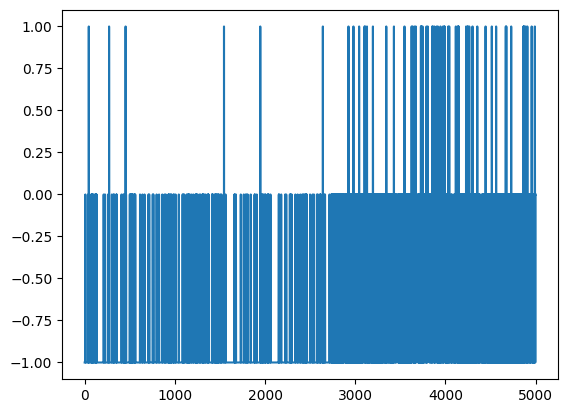

In [ ]:
LR = 1e-3
GAMMA = 0.7
EPISODES = 5000
MAX_STEPS = 800

env = SnakeEnv(grid_size=10, initial_length=3)
input_channels = 1
output_dim = env.action_space.n

policy = PolicyCNN(input_channels, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=LR)

rewards = train(env, policy, optimizer, num_episodes=EPISODES, gamma=GAMMA, max_steps=MAX_STEPS)

plt.plot(list(range(len(rewards))), rewards)
plt.show()

In [ ]:
env = SnakeEnv(grid_size=10)
cnn_policy = CNNAgentPolicy(policy)

state, _ = env.reset()
done = False

mean_reward, std_reward = evaluate_agent(env, 200, n_eval_episodes=50, policy=cnn_policy)
print(f'Mean reward: {mean_reward}, std: {std_reward}')

state, _ = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = cnn_policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    state = new_state
    images.append(env.render())

Mean reward: -0.42, std: 0.5688585061331156


In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=300)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
ani.save('snake_attempt2.mp4')

Episode 1/20000, Total Reward: -1, Loss: 0.048296332359313965
Episode 51/20000, Total Reward: -1, Loss: 0.5304692387580872
Episode 101/20000, Total Reward: -1, Loss: 2.1658718585968018
Episode 151/20000, Total Reward: -1, Loss: 0.2439139485359192
Episode 201/20000, Total Reward: -1, Loss: -3.1439871788024902
Episode 251/20000, Total Reward: -1, Loss: 1.8112571239471436
Episode 301/20000, Total Reward: -1, Loss: -3.0913209915161133
Episode 351/20000, Total Reward: -1, Loss: -0.7890685200691223
Episode 401/20000, Total Reward: -1, Loss: -0.5499861240386963
Episode 451/20000, Total Reward: -1, Loss: -1.1272872686386108
Episode 501/20000, Total Reward: -1, Loss: -1.758314609527588
Episode 551/20000, Total Reward: -1, Loss: 1.4328252077102661
Episode 601/20000, Total Reward: -1, Loss: -0.27247172594070435
Episode 651/20000, Total Reward: -1, Loss: -2.9795894622802734
Episode 701/20000, Total Reward: 0, Loss: 1.9392567873001099
Episode 751/20000, Total Reward: -1, Loss: -0.02622631937265396


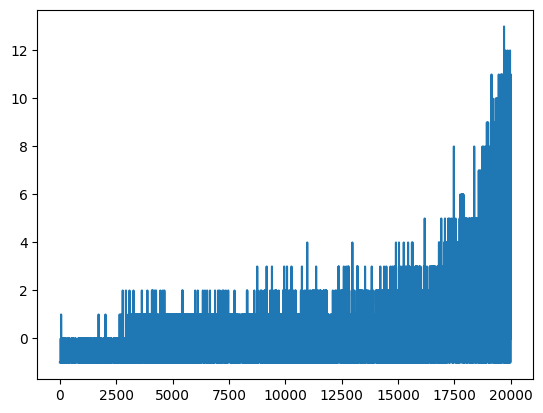

In [ ]:
LR = 1e-3
GAMMA = 0.9
EPISODES = 20000
MAX_STEPS = 500

env = SnakeEnv(grid_size=10, initial_length=3)
input_channels = 1
output_dim = env.action_space.n

policy = PolicyCNN(input_channels, output_dim)
optimizer = optim.Adam(policy.parameters(), lr=LR)

rewards = train(env, policy, optimizer, num_episodes=EPISODES, gamma=GAMMA, max_steps=MAX_STEPS)

plt.plot(list(range(len(rewards))), rewards)
plt.show()

In [ ]:
env = SnakeEnv(grid_size=10)
cnn_policy = CNNAgentPolicy(policy)

state, _ = env.reset()
done = False

mean_reward, std_reward = evaluate_agent(env, 200, n_eval_episodes=50, policy=cnn_policy)
print(f'Mean reward: {mean_reward}, std: {std_reward}')

state, _ = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = cnn_policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    state = new_state
    images.append(env.render())

Mean reward: 4.0, std: 2.7202941017470885


In [ ]:
state, _ = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = cnn_policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    state = new_state
    images.append(env.render())

In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=300)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
ani.save('snake_attempt3.mp4')

In [ ]:
# continue training
rewards = train(env, policy, optimizer, num_episodes=10000, gamma=GAMMA, max_steps=800)

plt.plot(list(range(len(rewards))), rewards)
plt.show()

Episode 1/10000, Total Reward: 3, Loss: -5.400044918060303
Episode 51/10000, Total Reward: 10, Loss: 7.65566349029541
Episode 101/10000, Total Reward: 5, Loss: -6.5998334884643555
Episode 151/10000, Total Reward: 11, Loss: -3.2124462127685547
Episode 201/10000, Total Reward: 10, Loss: -11.436569213867188
Episode 251/10000, Total Reward: 1, Loss: -3.6807382106781006
Episode 301/10000, Total Reward: 1, Loss: -3.0833144187927246
Episode 351/10000, Total Reward: 10, Loss: -10.848699569702148
Episode 401/10000, Total Reward: -1, Loss: -22.404085159301758
Episode 451/10000, Total Reward: -1, Loss: -0.7103056311607361
Episode 501/10000, Total Reward: 8, Loss: -1.5557280778884888
Episode 551/10000, Total Reward: 12, Loss: 3.9205996990203857
Episode 601/10000, Total Reward: 6, Loss: -17.16129493713379
Episode 651/10000, Total Reward: 7, Loss: -6.178785800933838
Episode 701/10000, Total Reward: 9, Loss: 2.177288055419922
Episode 751/10000, Total Reward: 4, Loss: -9.098502159118652
Episode 801/10

In [ ]:
env = SnakeEnv(grid_size=10)
cnn_policy = CNNAgentPolicy(policy)

state, _ = env.reset()
done = False

mean_reward, std_reward = evaluate_agent(env, 200, n_eval_episodes=50, policy=cnn_policy)
print(f'Mean reward: {mean_reward}, std: {std_reward}')

state, _ = env.reset()
images = []
images.append(env.render())

for step in range(100):
    action, _ = cnn_policy.act(state)
    new_state, reward, done, info = env.step(action)
    if done:
        break
    state = new_state
    images.append(env.render())

In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=300)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
ani.save('snake_attempt4.mp4')